In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits

# Bad Pixel Map

In [2]:
def load_plz(pattern):
    
    files = sorted(glob.glob(pattern))
    files = map(fits.open, files)
    files = [file[0].data.flatten() for file in files]
    return np.array(files)
    
def lazy_load_plz(pattern):
    
    files = sorted(glob.glob(pattern))
    files = map(fits.open, files)
    return files

def num_sd(arr):
    
    return np.abs(arr - arr.mean()) / arr.std()

In [3]:
darks = load_plz("data/*DARK*")
dark_master = np.median(darks, axis=0)

flats = load_plz("data/*FLAT*")
flat_master = np.median(flats, axis=0)
flat_master /= np.median(flat_master)

dark_sigma = num_sd(dark_master)
dark_mask = dark_sigma < 5

flat_sigma = num_sd(flat_master)
flat_mask = flat_sigma < 5

big_mask = flat_mask * dark_mask
dim = int(np.sqrt(len(big_mask)))
big_mask2d = np.reshape(big_mask, (dim, dim))

In [4]:
science_images = lazy_load_plz("data/Science_image*")
hdul = next(science_images)

mask_hdu = fits.PrimaryHDU(big_mask2d.astype(np.int32))
mask_hdul = fits.HDUList([mask_hdu])
try: mask_hdul.writeto(f"data/bad_pixels.fits")
except OSError: pass

# Convert Catalog Files to Light Curves

In [5]:
def load_cat(filename):

    return pd.read_csv(filename, sep=r'\s+', skiprows=5, header=None, names=['Num','Ra', 'Dec',
            'Flux', 'Flux_err'])

def load_time(file_num):
    
    file_name = "Science_image." + file_num + ".FIT"
    file, = lazy_load_plz("data/" +file_name)
    time_string = file[0].header["TIME-OBS"]
    h, m, s = map(float, time_string.strip().split(':'))
    seconds = 3600*h + 60*m + s
    return seconds

In [6]:
def distances(starcoords, catframe):
    """
    Compute angular distance between a reference star and all sources in a dataframe,
    assuming a small separation.
    """
    
    alpha, delta = starcoords
    dra = (alpha - catframe['Ra']) * np.cos(delta)
    ddec = delta - catframe['Dec']
    return np.sqrt(dra**2 + ddec**2)
    
def fuzzy_match(starcoords, catframe, eps=1e-3):
    """
    Match the star with the given coordinates to the nearest source in the frame. Returns
    None if the distance between the star and the closest match is > eps.
    """
    
    gamma = distances(starcoords, catframe)
    indx = gamma.idxmin()
    
    if gamma[indx] <= eps:
        return catframe.loc[indx]
    return None

In [7]:
def init_refstars(kitty):
    """ Select the set of stars to serve as reference stars from a dataframe. """
    
    kitty.sort_values(by='Flux', ascending=False, inplace=True)

    mask = kitty['Ra'] >= 300
    mask &= kitty['Ra'] <= 300.25
    mask &= kitty['Dec'] >= 22.5
    mask &= kitty['Dec'] <= 22.8

    masked_kitty = kitty[mask][:NUMREF]
    return np.array([masked_kitty['Ra'], masked_kitty['Dec']]).T

In [8]:
kitties = glob.glob("data/*.cat")
kitties = sorted(kitties)

In [9]:
t = np.zeros(len(kitties), dtype=np.float64)
NUMREF = 15
reference_stars = None
time_series = [list() for i in range(NUMREF)]
indices = [list() for i in range(NUMREF)]

for i, cat_name in enumerate(kitties):

    # Load the catalog file and the corresponding time
    kitty = load_cat(cat_name)
    cat_num = cat_name.split('.')[-3]
    time = load_time(cat_num)
        
    # Initialize the reference stars
    if reference_stars is None:
        reference_stars = init_refstars(kitty)
    # Skip the frame if no data exist
    if len(kitty) <= 0: continue
    
    # Loop through the refernce stars and try to locate them in the frame
    for j, starcoords in enumerate(reference_stars):
            
        match = fuzzy_match(starcoords, kitty)
        if match is not None:
            time_series[j].append(match)
            indices[j].append(i)
    
    # Log the time for this frame
    t[i] = time
    
    # Print progress
    prog = i / len(kitties)
    numspace = int(50*(1-prog))
    pbar = "[" + "#" * (50-numspace) + " " * numspace + "]"
    end = "" if i < len(kitties) - 1 else "\n"
    print(f"\r{pbar} {100*prog:.0f}%", end=end)

[##################################################] 100%


In [10]:
def get_field(row_list, field):
    """ Helper to make the generator comprehensions prettier. """
    
    return [row[field] for row in row_list]

# Get an array of fluxes for each star
flux = (get_field(row_list, "Flux") for row_list in time_series)
flux = list(map(np.array, flux))

# Get the corresponding uncertainties
flux_err = (get_field(row_list, "Flux_err") for row_list in time_series)
flux_err = list(map(np.array, flux_err))

# Get the mean for each star, and then divide by it
mu = [flux_arr.mean() for flux_arr in flux]
flux = [flux[i] / mu[i] for i in range(len(flux))]
flux_err = [flux_err[i] / mu[i] for i in range(len(flux_err))]

In [11]:
# Save all of the data files

if not os.path.isdir("lightcurves"):
    os.mkdir("lightcurves")

for i in range(NUMREF):
    if not os.path.isdir(f"lightcurves/star_{i}"):
        os.mkdir(f"lightcurves/star_{i}")

np.savetxt("lightcurves/ref_stars.csv", reference_stars, header="RA Dec", delimiter=",")
np.savetxt("lightcurves/times.csv", t, delimiter=",")

for i in range(NUMREF):
    np.savetxt(f"lightcurves/star_{i}/flux_{i}.csv", flux[i], delimiter=",")
    np.savetxt(f"lightcurves/star_{i}/flux_err_{i}.csv", flux_err[i], delimiter=",")
    np.savetxt(f"lightcurves/star_{i}/indices_{i}.csv", indices[i], delimiter=",")

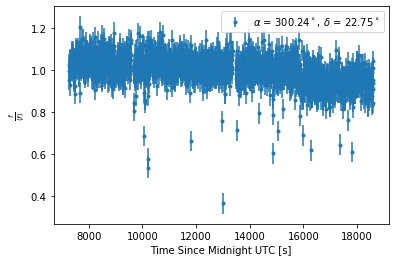

In [12]:
# Plot and save lightcurves
# I tried a bunch of subplots, but they weren't really readable

for i in range(NUMREF):

    ra, dec = reference_stars[i]
    plt.errorbar(t[indices[i]], flux[i], flux_err[i], fmt='.',
            label=rf"$\alpha$ = {ra:.2f}$^\circ$, $\delta$ = {dec:.2f}$^\circ$")
    plt.xlabel("Time Since Midnight UTC [s]")
    plt.ylabel(r"$\frac{f}{\langle f \rangle}$")
    plt.legend()
    plt.savefig(f"lightcurves/star_{i}/lightcurve_{i}.png", dpi=600)
    if i < NUMREF-1: plt.gcf().clear()

# Extract Transit and Compute Properties

In [13]:
class Star:
    """ Class for storing and manipulating star light curve data. """

    starcoords = np.loadtxt("lightcurves/ref_stars.csv", delimiter=",")
    times = np.loadtxt("lightcurves/times.csv", delimiter=",")

    def __init__(self, index):

        directory = f"lightcurves/star_{index}"
        self.ra, self.dec = self.starcoords[index]
        self.flux = np.loadtxt(os.path.join(directory, f"flux_{index}.csv"), delimiter=",")
        self.flux_err = np.loadtxt(os.path.join(directory, f"flux_err_{index}.csv"), delimiter=",")
        self.indices = np.loadtxt(os.path.join(directory, f"indices_{index}.csv"), dtype=np.int32, delimiter=",")

    def __str__(self):

        return f"Star(RA={self.ra:.3f}, Dec={self.dec:.3f})"

    def trim(self, sigma_tol=3):
        """ Trim points a certain number of standard deviations from the mean flux. """

        mu_flux = self.flux.mean()
        std_flux = self.flux.std()
        num_sd = np.abs(self.flux - mu_flux) / std_flux

        mask = num_sd <= sigma_tol
        self.flux = self.flux[mask]
        self.flux_err = self.flux_err[mask]
        self.indices = self.indices[mask]

    def plot(self, binsize=None, figsize=(12, 9), vlines=()):
        """ Plot the star's light curve, binning if a binsize is provided. """

        if binsize is None:
            times = self.times[self.indices]
            flux = self.flux
            flux_err = self.flux_err
        else:
            times = np.arange(Star.times[0] + binsize/2, Star.times[-1] - binsize/2, step=binsize)
            flux, flux_err = self.bin_fluxes(binsize)
            flux = flux[:len(times)]
            flux_err = flux_err[:len(times)]
            
        label = rf"$\alpha$ = {self.ra:.2f}$^\circ$, $\delta$ = {self.dec:.2f}$^\circ$"
        plt.errorbar(times / 3600, flux, flux_err, fmt='.',
                    label=label, markersize=8, capsize=2)
        plt.xlabel("Time Since Midnight UTC [h]")
        plt.ylabel(r"$\frac{f}{\langle f \rangle}$")
        plt.legend()

        for vline in vlines:
            plt.axvline(vline / 3600, color='black', linestyle='--')

        plt.gcf().set_size_inches(figsize)

    def bin_fluxes(self, binsize):
        """
        Bin fluxes into bins of the given size. Return the mean flux in each bin,
        and the uncertainty. Uncertainty is the std divided by sqrt(numpoints).
        """

        nbins = (Star.times[-1] - Star.times[0]) / binsize
        scalefac = nbins / len(Star.times)
        bindices = np.floor(self.indices * scalefac)
        bindices = bindices.astype(np.int32)

        binned_flux = np.zeros(bindices.max() + 1)
        exp_flux2 = np.zeros(len(binned_flux))
        counts = np.zeros(len(binned_flux), dtype=np.int32)
        
        for i in range(len(self.flux)):
            
            binned_flux[bindices[i]] += self.flux[i]
            exp_flux2[bindices[i]] += self.flux[i]**2
            counts[bindices[i]] += 1

        binned_flux /= counts
        exp_flux2 /= counts
        sigma = np.sqrt((exp_flux2 - binned_flux**2) / counts)

        return binned_flux, sigma

In [14]:
def keep_frames_with_all(stars):
    """ Drops frames where not all stars are visible. """

    counts = np.zeros(len(Star.times), dtype=np.int32)

    for star in stars:
        counts[star.indices] += 1

    mask = counts == len(stars)
    indices = np.arange(0, len(Star.times), dtype=np.int32)
    indices = indices[mask]
    indices = set(indices)
    
    @np.vectorize
    def valid_indices(i):
        return i in indices
    
    for star in stars:

        mask = valid_indices(star.indices)
        star.flux = star.flux[mask]
        star.flux_err = star.flux_err[mask]
        star.indices = star.indices[mask]

In [15]:
def err_weighted_mean(stars):
    """ Compute an uncertainty-weighted mean, returning the mean and its uncertainty. """

    mu = np.zeros(len(Star.times))
    sigma = np.zeros(len(Star.times))

    for star in stars:

        mu[star.indices] += star.flux / star.flux_err**2
        sigma[star.indices] += 1 / star.flux_err**2

    mu[mu == 0.0] = 1.0
    sigma[sigma == 0.0] = 1.0

    mu /= sigma
    sigma = np.sqrt(1 / sigma)

    return mu, sigma

In [16]:
# Load stars
main_star = Star(0)
ref_stars = list(map(Star, range(1, 11)))

In [17]:
# Trim outliers from the light curves
# The tolerance here is 3 sigma

main_star.trim()
for star in ref_stars:
    star.trim()

In [18]:
keep_frames_with_all([main_star] + ref_stars)

In [19]:
# Compute weighted mean of reference star fluxes
mu, sigma = err_weighted_mean(ref_stars)
# Divide that out of our star's flux
main_star.flux = main_star.flux / mu[main_star.indices]
# Need to account for error in mu
main_star.flux_err = main_star.flux_err / mu[main_star.indices]

In [20]:
# Figure out which times correspond to the baseline flux
baseline_mask = Star.times[main_star.indices] < 9500
baseline_mask |= Star.times[main_star.indices] > 15700

# Do a linear fit - there is a slight increase in flux
baseline_times = Star.times[main_star.indices][baseline_mask]
baseline_flux = main_star.flux[baseline_mask]
baseline_flux_err = main_star.flux_err[baseline_mask]
m, b = np.polyfit(baseline_times, baseline_flux, 1, w=1/baseline_flux_err)
baseline = m*Star.times[main_star.indices] + b

# Divide out the baseline flux
main_star.flux /= baseline
main_star.flux_err /= baseline

In [21]:
# Estimate start and end times for the transit, peak transit

binsize = 180
time_bounds = Star.times[0] + binsize/2, Star.times[-1] - binsize/2,
bintimes = np.arange(*time_bounds, step=binsize)
binned_flux, binned_flux_err = main_star.bin_fluxes(binsize)
binned_flux = binned_flux[:len(bintimes)]
binned_flux_err = binned_flux_err[:len(bintimes)]

def part_of_dip(i):
    """ Determine if a point is part of the dip. """

    meets_thresh = binned_flux[i] <= thresh
    left_mt = right_mt = False
    if i > 0: left_mt = binned_flux[i-1] <= thresh
    if i < len(bintimes)-1: right_mt = binned_flux[i+1] <= thresh
    return meets_thresh & (left_mt | right_mt)

thresh = 0.982
transit_mask = list(map(part_of_dip, range(len(binned_flux))))
peak_transit_times = bintimes[transit_mask]
peak_transit_bounds = peak_transit_times[0], peak_transit_times[-1]
    
thresh = 0.9975
transit_mask = list(map(part_of_dip, range(len(binned_flux))))
transit_times = bintimes[transit_mask]
transit_bounds = transit_times[0], transit_times[-1]

start, end = peak_transit_bounds
peak_transit = Star.times[main_star.indices] > start
peak_transit &= Star.times[main_star.indices] < end
transit_flux = main_star.flux[peak_transit]

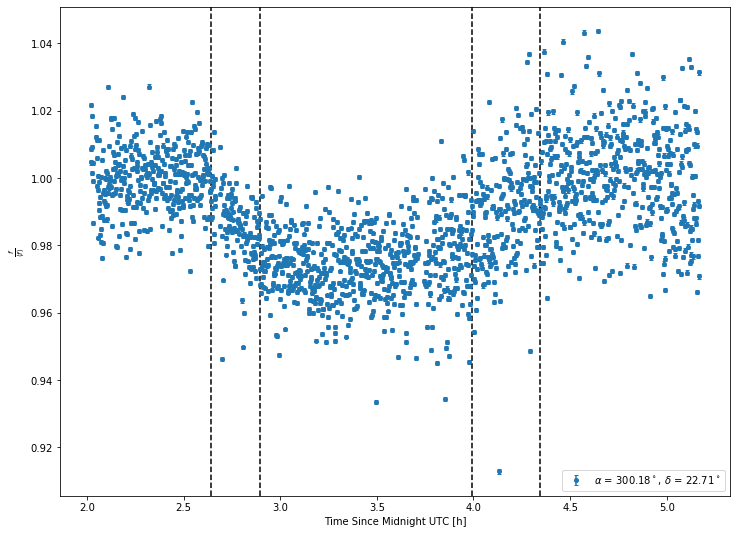

In [22]:
# Plot without binning
main_star.plot(vlines=transit_bounds+peak_transit_bounds)

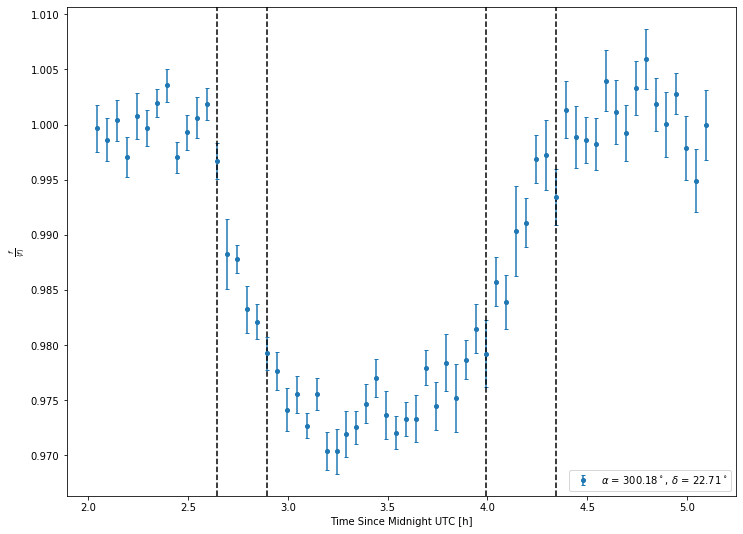

In [23]:
# Plot with binning
main_star.plot(binsize, vlines=transit_bounds+peak_transit_bounds)

In [24]:
# Compute transit midpoint
midpoint = np.median(transit_times)
minutes = midpoint // 60 % 60
hours = (midpoint // 3600 - 4) % 24
print(f"Midpoint: {hours:.0f}:{minutes:.0f} +- 00:03")

Midpoint: 23:29 +- 00:03


In [25]:
# Compute transit depth
transit_depth = 1 - transit_flux.mean()
transit_depth_err = transit_flux.std() / np.sqrt(len(transit_flux))
print(f"Transit Depth: {transit_depth:.4f} +- {transit_depth_err:.4f}")

Transit Depth: 0.0252 +- 0.0004


In [26]:
# Planet radius
rad_rat = np.sqrt(transit_depth)
rad_rat_err = transit_depth_err / (2 * rad_rat)
print(f"Radius Ratio: {rad_rat:.3f} +- {rad_rat_err:.3f}")

Radius Ratio: 0.159 +- 0.001


In [27]:
lit_rat = 0.10049*1.138 / 0.805
lit_rat_err = np.sqrt((0.027*0.10049 / 0.805)**2 + (0.10049*1.138 / 0.805**2 * 0.016)**2)
    
comb_err = np.sqrt(rad_rat_err**2 + lit_rat_err**2)
num_sd = (rad_rat - lit_rat) / comb_err
print(f"Literature Value: {lit_rat:.3f} +- {lit_rat_err:.3f}")
print(f"Error: {num_sd:.2f} sigma")

Literature Value: 0.142 +- 0.004
Error: 3.62 sigma
